# Use the follwing cell only if you execute OpenMC on Colab google platform, it you are using OpenMC on your own machine please skip the following cell.

In [ ]:
# Installation of OpenMC on Colab google (online use)
# Initialization of the time counting
from time import time
t0 = time()

# Import  OpenMC code source from github
!git clone https://github.com/mit-crpg/openmc.git

# Verifiying the imported OpenMC
!pwd
%cd openmc
!git checkout master
!mkdir build
%cd build

# Making the installation files 
# ----------------------------------------------------------------------------------
# Alternative 1: according to "Jose_Ignacio_Marquez"
#!cmake ../ -DPYTHON_EXECUTABLE=/usr/bin/python3 -DCMAKE_INSTALL_PREFIX=/usr/local
# ----------------------------------------------------------------------------------
# Alternative 2: according to "OpenMC installation guide"
!cmake ..
# ----------------------------------------------------------------------------------

# Build the files
# ----------------------------------------------------------------------------------
# Alternative 1: Using all the available cores to execute an infinite jobs
# this option may fo faster untill 96% then RAM could be saturated !!! still ???
# ! make -j
# ----------------------------------------------------------------------------------
# Alternative 2: Using the default command (it is safe but it takes about 4 min)
! make
# ----------------------------------------------------------------------------------

# Install the code
! make install

# Install OpenMC wheel for python
%cd /content/openmc
!pip install .

# Timing "OpenMC" installation
t1 = time()

# Getting and extracting nuclear data 
# Alternative 1: lightest package from nndc (about 500 MO)
%cd /content
! wget https://anl.box.com/shared/static/teaup95cqv8s9nn56hfn7ku8mmelr95p.xz
!mv teaup95cqv8s9nn56hfn7ku8mmelr95p.xz nndc_hdf5.xz
print('Extracting data files')
!tar -xvf nndc_hdf5.xz
# Alternative 2: Jeff32 package (about 1.8 GO)
#! wget https://anl.box.com/shared/static/pb94oxriiipezysu7w4r2qdoufc2epxv.xz
#!mv pb94oxriiipezysu7w4r2qdoufc2epxv.xz jeff32.xz
#print('Extracting data files')
#!tar -xvf jeff32.xz
# Alternative 3: ENDF/B-VIII.0 package (about 3.4 GO)
#! wget https://anl.box.com/shared/static/nd7p4jherolkx4b1rfaw5uqp58nxtstr.xz
#!mv nd7p4jherolkx4b1rfaw5uqp58nxtstr.xz endf_B80.xz
#print('Extracting data files')
#!tar -xvf endf_B80.xz
# Path definition for nuclear data folder
import os
# for nndc_hdf5
os.environ['OPENMC_CROSS_SECTIONS'] = "/content/nndc_hdf5/cross_sections.xml"
#for jeff32
#os.environ['OPENMC_CROSS_SECTIONS'] = "/content/jeff32/cross_sections.xml"
#for endf_B80
#os.environ['OPENMC_CROSS_SECTIONS'] = "/content/endf_B80/cross_sections.xml"
# Timing "Nuclear data import and extarcting"

# Finish by install Imagemagick for ppm to png files conversion
!apt-get install imagemagick

t2 = time()

# Time estimation of the whole operation "OpenMC + Nuclear Data"
print("-------------------------------------------------------------------------------")
print("Code install time = "+str((t1-t0)/60.0)+" min.")
print("-------------------------------------------------------------------------------")
print("Library install time = "+str((t2-t1)/60.0)+" min.")
print("-------------------------------------------------------------------------------")
print("Total time to get OpenMC ready on Colab.research = "+str((t2-t0)/60.0)+" min.")
print("-------------------------------------------------------------------------------")


# For Installed OpenMC, you can start from here


In [1]:
# Initialize third-party libraries and the OpenMC Python API
import matplotlib.pyplot as plt
import numpy as np
import openmc
import openmc.model

%matplotlib inline

## MODEL definition

In [2]:
# Create the pin materials
def build_model(Gado):
  global r_core, batches, Uo2_fract
  enr0= 3.0/100
  enr = enr0 * 1.3
  Uo2 =openmc.Material(name='Mix_fuel')
  Uo2.set_density('g/cm3', 10.50)
  Uo2.add_nuclide('U235', enr)
  Uo2.add_nuclide('U238', (1-enr))
  Uo2.add_element('O', 2.0)

  Tho2=openmc.Material(name='Tho2')
  Tho2.add_element('Th',1.0)
  Tho2.add_element('O',2.0)
  Tho2.set_density('g/cm3',9.0)

  Gd2o3=openmc.Material (name='Gd2o3')
  Gd2o3.set_density('g/cm3', 7.407)
  Gd2o3.add_element('Gd', 2)
  Gd2o3.add_element('O', 3)

  Uo2_fract = 0.9999 #[%] this is the value to modify by user <<<<<<<<<<<<<<<<<<<<<<<<
  Tho2_fract = (1-Uo2_fract) #[%]
  Gd2o3_fract= Gado 
  Mix_fuel1=openmc.Material.mix_materials([Uo2,Tho2],[Uo2_fract,1-Uo2_fract],'vo',name='Fuel01')
  Mix_fuel2=openmc.Material.mix_materials([Uo2,Tho2, Gd2o3],[(1-Gado)*Uo2_fract,(1-Gado)*(1-Uo2_fract), Gado],'vo', name='Fuel02')
  # The gap
  gas = openmc.Material(name="gas")
  gas.set_density("g/cc",1.47e-2)
  gas.add_element("He",1.0,percent_type="ao")
  # The cladding (Zirconium)
  zircaloy = openmc.Material(name='Zircaloy')
  zircaloy.set_density('g/cm3', 6.55)
  zircaloy.add_element('Zr', 1.0)
  # The moderator
  water = openmc.Material(name='Water')
  water.set_density('g/cm3', 0.741)
  water.add_element('H', 2.0)
  water.add_element('O', 1.0)
  water.add_s_alpha_beta('c_H_in_H2O')
  #material list 
  materials = openmc.Materials([Mix_fuel1, Mix_fuel2, zircaloy, water, gas])
  materials.export_to_xml()
  # Core reactor dimensions
  h_fuel = 100. # cm Fuel pin hight
  h_core = 150. # cm Core hight
  r_core = 75. # cm Core radius

  # Pincell dimensions
  r_fo = 0.41295 # cm, fuel outer radius
  r_ci = 0.41895 # cm, clad inner radius
  r_co = 0.47610 # cm, clad outer radius

  # Numbers of pincell and assemblies
  N_pcf = 17 # 17 x 17 pincells by fuel assembly
  N_assy = 6 # 24 assembly arranged as cross with 6x6 big axes
  # Pitch dimensions
  pitch = 1.2626 # cm, pincell pitch
  a_pitch = N_pcf*pitch # cm, assembly pitch
  c_pitch = N_assy*a_pitch
  #  "Geometry.xml" 
  # Define the cells and geometry
  ## Define the fuel pin and  cladding cylinder surfaces
  # Create cylinders for the fuel and clad
  cyl_fuel = openmc.ZCylinder(r=r_fo)
  cyl_ci = openmc.ZCylinder(r=r_ci)
  cyl_co = openmc.ZCylinder(r=r_co)
  cyl_t = openmc.ZPlane(z0=h_fuel/2.) 
  cyl_b = openmc.ZPlane(z0=-h_fuel/2.) 
  # Create boundary planes for fuel assembly
  min_xa = openmc.XPlane(x0=-a_pitch/2.)
  max_xa = openmc.XPlane(x0=+a_pitch/2.)
  min_ya = openmc.YPlane(y0=-a_pitch/2.)
  max_ya = openmc.YPlane(y0=+a_pitch/2.)
  min_za = openmc.ZPlane(z0=-h_fuel/2.)
  max_za = openmc.ZPlane(z0=+h_fuel/2.)
  # Planes for core box
  min_xc = openmc.XPlane(x0=-c_pitch/2.)
  max_xc = openmc.XPlane(x0=+c_pitch/2.)
  min_yc = openmc.YPlane(y0=-c_pitch/2.)
  max_yc = openmc.YPlane(y0=+c_pitch/2.)
  min_zc = openmc.ZPlane(z0=-h_core, boundary_type='vacuum')
  max_zc = openmc.ZPlane(z0=+h_core, boundary_type='vacuum')
  #Core barrel
  cyl_core = openmc.ZCylinder(r=r_core, boundary_type='vacuum')
  #Outer_Barrel = openmc.ZCylinder(r=85, boundary_type='transmission')
  #Up_Barrel = openmc.ZPlane(z0=+50, boundary_type='transmission')
  #Low_Barrel = openmc.ZPlane(z0=-50, boundary_type='transmission')

  # standard fuel pincell
  fuel_cell1 = openmc.Cell(name='Fuel01', fill=Mix_fuel1, region=-cyl_fuel)
  # gap cell
  gap_cell1 = openmc.Cell(name='Gap01', fill=gas, region=-cyl_ci & +cyl_fuel)
  # cladding cell
  clad_cell1 = openmc.Cell(name='Clad01', fill=zircaloy, region=-cyl_co & +cyl_ci)
  # coolant outside the pin
  coolant_cell1 = openmc.Cell()
  coolant_cell1.fill = water
  coolant_cell1.region = +cyl_co & +cyl_b & -cyl_t # note: infinite in extent

  # Poisened fuel pincell (with Gadolina)  
  fuel_cell2 = openmc.Cell(name='Fuel02', fill=Mix_fuel2, region=-cyl_fuel)
  gap_cell2 = openmc.Cell(name='Gap02', fill=gas, region=-cyl_ci & +cyl_fuel)
  # cladding Poisened cell
  clad_cell2 = openmc.Cell(name='Clad02', fill=zircaloy, region=-cyl_co & +cyl_ci)
  # coolant outside the poisened pin
  coolant_cell2 = openmc.Cell()
  coolant_cell2.fill = water
  coolant_cell2.region = +cyl_co & +cyl_b & -cyl_t # note: infinite in extent

  assy_region = +min_xc & -max_xc & +min_yc & -max_yc & +min_za & -max_za
  out_assy_region = -min_xc | +max_xc | -min_yc | +max_yc | -min_za | +max_za

  core_region = -cyl_core & -max_zc & +min_zc

  # outer core water
  c_outer = openmc.Cell()
  c_outer.fill = water
  c_outer.region =-cyl_core & -max_zc & +min_zc & out_assy_region 
  # pincell universe
  fpc1 = openmc.Universe();
  fpc1.add_cells([fuel_cell1,gap_cell1,clad_cell1,coolant_cell1])

  fpc2 = openmc.Universe();
  fpc2.add_cells([fuel_cell2,gap_cell2,clad_cell2,coolant_cell2])

  # to be used as exterior cell for core lattices
  water_cell = openmc.Cell()
  water_cell.fill = water
  # all water universe
  all_water = openmc.Universe()
  all_water.add_cell(water_cell)
  
  # fuel pins assembly lattice (seed assembly)
  FPL1 = openmc.RectLattice()
  #FPL.center = (0.,0.)
  FPL1.dimension = [N_pcf,N_pcf]
  FPL1.lower_left = [-a_pitch/2.,-a_pitch/2.]
  FPL1.pitch = [pitch,pitch]
  FPL1.universes =[[fpc1]*17]*17 
  FPL1.outer = all_water
  
  # fuel assembly lattice with some Gd-rods
  FPL2 = openmc.RectLattice()
  #FPL.center = (0.,0.)
  FPL2.dimension = [N_pcf,N_pcf]
  FPL2.lower_left = [-a_pitch/2.,-a_pitch/2.]
  FPL2.pitch = [pitch,pitch]
  L01 = [fpc1]*17
  L02 = [fpc1]*3+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]*3             
  L03 = [fpc1]*17 
  L04 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]   
  L05 = [fpc1]*6+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]*6       
  L06 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]  
  L07 = [fpc1]*4+[fpc2]+[fpc1]*7+[fpc2]+[fpc1]*4     
  L08 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]
  L09 = [fpc1]*4+[fpc2]+[fpc1]*3+[fpc2]+[fpc1]*3+[fpc2]+[fpc1]*4 
  L10 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]
  L11 = [fpc1]*4+[fpc2]+[fpc1]*7+[fpc2]+[fpc1]*4
  L12 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]
  L13 = [fpc1]*6+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]*6
  L14 = [fpc1]+[fpc2]+[fpc1]*13+[fpc2]+[fpc1]
  L15 = [fpc1]*17
  L16 = [fpc1]*3+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]+[fpc2]+[fpc1]*3 
  L17 = [fpc1]*17 
  FPL2.universes =[L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12,L13,L14,L15,L16,L17] 
  FPL2.outer = all_water

  # fuel+Gd pins assembly lattice
  FPL3 = openmc.RectLattice()
  #FPL.center = (0.,0.)
  FPL3.dimension = [N_pcf,N_pcf]
  FPL3.lower_left = [-a_pitch/2.,-a_pitch/2.]
  FPL3.pitch = [pitch,pitch]
  FPL3.universes =[[fpc2]*17]*17 
  FPL3.outer = all_water

  # universe corresponding to a seed assembly
  A = openmc.Universe()
  FPL1_cell = openmc.Cell()
  FPL1_cell.fill = FPL1
  FPL1_cell.region = assy_region
  A.add_cell(FPL1_cell)

  # universe corresponding to a mixed rods assembly
  B = openmc.Universe()
  FPL2_cell = openmc.Cell()
  FPL2_cell.fill = FPL2
  FPL2_cell.region = assy_region
  B.add_cell(FPL2_cell)

  # universe corresponding to a fue+Gd assembly
  C = openmc.Universe()
  FPL3_cell = openmc.Cell()
  FPL3_cell.fill = FPL3
  FPL3_cell.region = assy_region
  C.add_cell(FPL3_cell)

  # water lattice
  WL = openmc.RectLattice()
  WL.dimension = [N_pcf,N_pcf]
  WL.lower_left = [-a_pitch/2.,-a_pitch/2.]
  WL.pitch = [pitch,pitch]
  WL.universes = [[all_water]*17]*17
 
  WL.outer = all_water

  W = openmc.Universe()
  water_cell = openmc.Cell()
  water_cell.region = assy_region
  water_cell.fill = WL
  W.add_cell(water_cell)

  # core lattice
  CL = openmc.RectLattice();
  CL.dimension = [N_assy,N_assy];
  CL.lower_left = [-c_pitch/2.,-c_pitch/2.]
  CL.pitch = [a_pitch,a_pitch];
  CL.universes = [
    [W,W,A,A,W,W],
    [W,A,A,A,A,W],
    [A,A,B,B,A,A],
    [A,A,B,B,A,A],
    [W,A,A,A,A,W],
    [W,W,A,A,W,W],   
  ]
  CL.outer = all_water;

  CORE = openmc.Universe();
  core_cell = openmc.Cell();
  core_cell.region = core_region;
  core_cell.fill = CL;
  CORE.add_cell(core_cell);
  root_univ = openmc.Universe();

  all_assy = openmc.Cell();
  all_assy.region = assy_region
  all_assy.fill = CORE

  ref_cell = openmc.Cell();
  ref_cell.region = core_region & out_assy_region
  ref_cell.fill = water

  root_univ.add_cells([all_assy,ref_cell])

  geometry = openmc.Geometry();
  geometry.root_universe = root_univ;
  geometry.export_to_xml();

  batches = 100
  settings = openmc.Settings();
  settings.run_mode = 'eigenvalue';
  settings.particles = 5000;
  settings.batches = batches;
  settings.inactive = 20;

  box = openmc.stats.Box(lower_left=(-c_pitch/2.,-c_pitch/2.,-h_fuel/2.),
                      upper_right=(c_pitch/2.,c_pitch/2.,h_fuel/2.),
                      only_fissionable=True);

  src = openmc.Source(space=box);
  settings.source = src;

  settings.export_to_xml();
  model = openmc.model.Model(geometry, materials, settings)
    
  return model # , r_core, batches
 

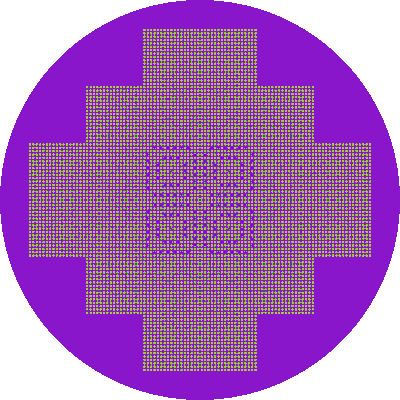

In [3]:
# Execute the model 
build_model(0.06)
# Prepare your canevas and template
plot = openmc.Plot()
plot.filename = 'assembly_xy'
plot.origin=[0,0,0]
plot.width = (150, 150)
plot.pixels = (400, 400)
plot.color_by = 'material'
# Show plot
# openmc.plot_inline(plot)
# or ...
plot.to_ipython_image()

In [3]:
# model, r_core, batches = build_model(0.06)
model = build_model(0.06)

#----------- Prepare and Create "Tallies.xml" file ---------------------------
# Define the Tallies
# Instantiate an empty Tallies object
tallies = openmc.Tallies()
#-------------------------------------------------------------------------------
# Distribution tally ----------------------------------------------------------
# Create mesh which will be used for tally
dim = 75 # This value define the precision and resolution of the mesh (pixel/cm)
side = r_core/1. # you can divide r_core by values greater than 1 to show only part of the assembly
n = 2 # multiplication number to set (>= 1)
mesh = openmc.RegularMesh()
mesh.dimension = [dim*n, dim*n]
mesh.lower_left = [-side, -side]
mesh.upper_right = [side, side]
# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)
# Create mesh tally to score flux and fission rate
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
# Define the nucleide of interest and scores we want to get
tally.scores = ['flux', 'fission', 'absorption', '(n,gamma)']

# Spectrum Tally2 --------------------------------------------------------------
# Create equal-lethargy energies to put in filter
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
e_filter = openmc.EnergyFilter(energies)
# Create tally with energy filter
tally2 = openmc.Tally()
tally2.filters = [e_filter]
tally2.scores = ['flux']

# Set model tallies
model.tallies = [tally, tally2]
#tallies.export_to_xml()
#model.tallies

In [4]:
!rm *.h5
model.run()

rm: cannot remove '*.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%

PosixPath('/home/bentridi/Documents/openmc_tests/PhD_ZICHE/Gadolina/statepoint.100.h5')

In [5]:
# Load the statepoint file
file_name = f'statepoint.{batches}.h5'
sp = openmc.StatePoint(file_name)
# interpreting Tally1
#tally1 = sp.tallies[tally1]
tally = sp.get_tally(scores=['flux'])
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
capture = tally.get_slice(scores=['(n,gamma)'])

In [6]:
flux

Tally
	ID             =	3
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength

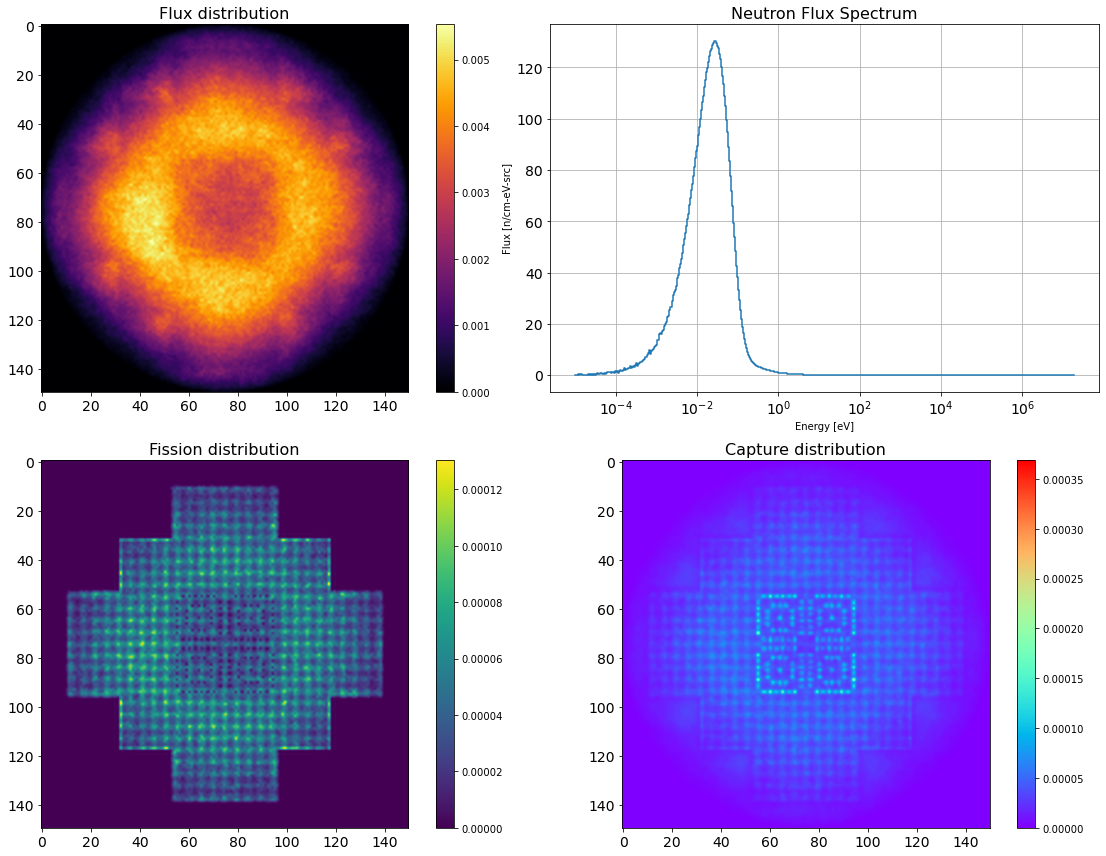

In [11]:
# interpreting Tally2
#tally2 = sp.get_tally(scores=['spectrum'])

shape = dim*n
flux.std_dev.shape = (shape, shape)
flux.mean.shape = (shape, shape)
fission.std_dev.shape = (shape, shape)
fission.mean.shape = (shape, shape)
capture.std_dev.shape = (shape, shape)
capture.mean.shape = (shape, shape)


#fig = plt.subplot()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True ) #, ncols=2,nrows=2,
Flux = ax1.imshow(flux.mean, cmap='inferno',  interpolation='spline36') #vmax=0.0038, 
ax1.set_title('Flux distribution', size=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
fig.colorbar(Flux, ax=ax1)

Fission = ax3.imshow(fission.mean,  interpolation='spline36') # vmax=2e-5, 
ax3.set_title('Fission distribution', size=16)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
fig.colorbar(Fission, ax=ax3)

Capture = ax4.imshow(capture.mean, cmap='rainbow',  interpolation='bicubic') #  vmax=2.9e-5,
ax4.set_title('Capture distribution', size=16)
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
fig.colorbar(Capture, ax=ax4)

t = sp.tallies[tally2.id]
flux500_mean = t.mean.ravel()
flux500_unc = t.std_dev.ravel()
ax2.step(energies[:-1], flux500_mean, where='post', label='flux spectrum')# this the flux spectrum as En function 
# ax2.step(energies[:-1], flux500_mean/np.diff(energies), where='post', label='flux spectrum')# This the flux/lethargy 
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel('Energy [eV]')
ax2.set_ylabel('Flux [n/cm-eV-src]')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_title('Neutron Flux Spectrum', size=16)
ax2.grid()
#ax2.legend()
# plt.savefig('Mix_fuel_tallies.jpg', dpi=300)

#fig.imshow(flux.mean, cmap='jet')
#fig.colorbar()